In [31]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch 
import utils

## Optimizers

[An overview of gradient descent optimization algorithms](http://ruder.io/optimizing-gradient-descent/)

We retrace the steps from the gradient descent notebook. We will start with first 100 rows of data.

In [3]:
data = np.load("sgd_data.npy").astype('float32')
rxs = data[:400,0]
rys = data[:400,1]

and displaying it:

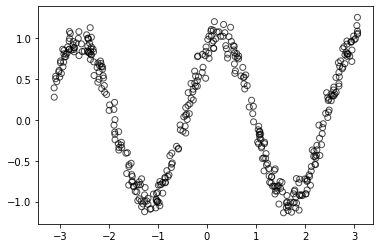

In [4]:
plt.scatter(rxs,rys, alpha=0.7, color='none', edgecolor="black");

In [5]:
def fitf(x,o,t):
    return np.sin(x*o+t)

def fitf_tensor(x,o,t):
    return np.moveaxis(np.sin(np.tensordot(np.atleast_1d(x),o,0)+t),0,-1)

def mse(f, x, y, o, t):
        err = f(x,o,t)-y
        return 0.5*np.sum(err*err, axis=-1)/len(x)

In [6]:
grid_size = 400
os = np.linspace(0, 7, grid_size)
ts = np.linspace(-np.pi,np.pi,grid_size)
otg = np.meshgrid(os,ts)

vg = mse(fitf_tensor, rxs, rys, otg[0], otg[1])

In [7]:
def grad(x,y, o, t):
    return np.array((
        -2*np.sum((y-np.sin(o*x+t))*np.cos(o*x+t)*x),
        -2*np.sum((y-np.sin(o*x+t))*np.cos(o*x+t))
    ))/len(x)

In [8]:
t_rxs = torch.from_numpy(rxs)
t_rys = torch.from_numpy(rys)

In [9]:
loss_f = torch.nn.MSELoss()

In [10]:
p = torch.FloatTensor([3.2, -0.4])
p.requires_grad_(True);
gd = torch.optim.SGD([p], lr=0.2)

fig_gd, ax =  plt.subplots(1,2,figsize=(16,8))
ax[0].contourf(otg[0], otg[1],vg, levels=20)
ax[0].scatter([p[0].item()], [p[1].item()],c='none', s=20, edgecolor='red')
trajectory_list=[]
n_iter = 75
for i in range(n_iter):
    gd.zero_grad()
    prediction = torch.sin(t_rxs*p[0]+p[1])
    loss = loss_f(prediction, t_rys)
    loss.backward()
    gd.step()
    np_p = p.detach().numpy()
    trajectory_list.append(np.concatenate((p.grad.numpy(),np_p,[mse(fitf,rxs, rys,*np_p)])))
    ax[0].scatter([np_p[0]], [np_p[1]],c='red', s=20, edgecolor='red')

trajectory_gd=np.stack(trajectory_list)
utils.plot_grad_and_trajectory(ax[1], trajectory_gd)
ax[1].set_xlabel("epoch")
plt.close()

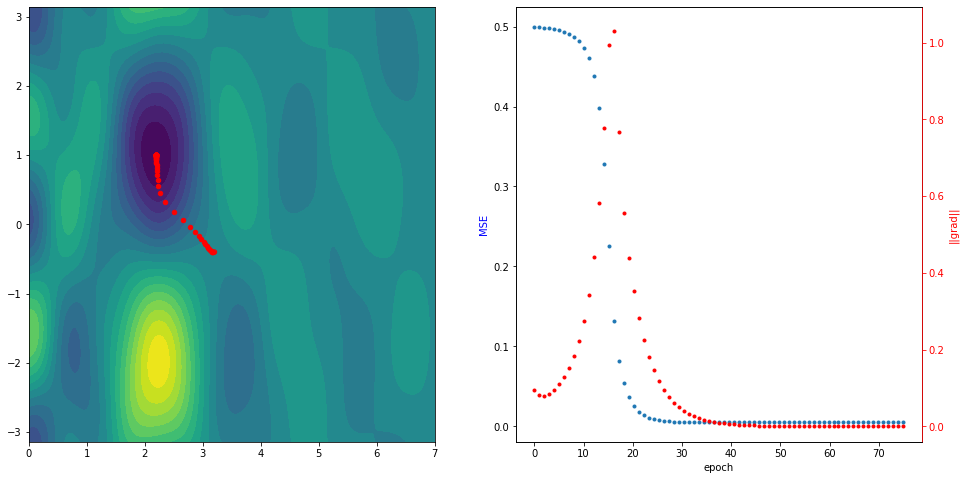

In [11]:
fig_gd

### Gradient descent with momentum

### Ravine

In [12]:
rav_par = np.asarray([1.0,10.0]).astype('float32')
def ravine(p0,p1):
    return 0.5*((rav_par[0]*p0)**2+(rav_par[1]*p1)**2)

In [13]:
grid_size = 400
os_rav = np.linspace(-10,10, grid_size)
ts_rav = np.linspace(-10,10,grid_size)
otg_rav = np.meshgrid(os_rav,ts_rav)

vg_rav = ravine(otg_rav[0], otg_rav[1])

In [14]:
def descend_ravine(n_iter, p,optim):
    trajectory_list=[]
    
    for i in range(n_iter):
        optim.zero_grad()

        loss = 0.5*torch.sum((torch.from_numpy(rav_par)*p)**2)
        loss.backward()
        np_p = p.detach().numpy()
        trajectory_list.append(np.concatenate((p.grad.numpy(),np_p,[ravine(*np_p)])))
        optim.step()
        
    trajectory = np.stack(trajectory_list)
    
    return trajectory

def plot_ravine(ax,trajectory):
    ax.contourf(otg_rav [0], otg_rav[1],vg_rav, levels=20)
    ax.scatter(trajectory[:,2], trajectory[:,3],c='none', s=20, edgecolor='red')
    ax.plot(trajectory[:,2], trajectory[:,3], 'r-')

In [15]:
p = torch.FloatTensor([-8, 3])
p.requires_grad_(True);
gd = torch.optim.SGD([p], lr=0.0195)
fig_rav, ax =  plt.subplots(1,2,figsize=(16,8))


trajectory_gd = descend_ravine(75,p,gd)
plot_ravine(ax[0], trajectory_gd)
utils.plot_grad_and_trajectory(ax[1], trajectory_gd)

plt.close()

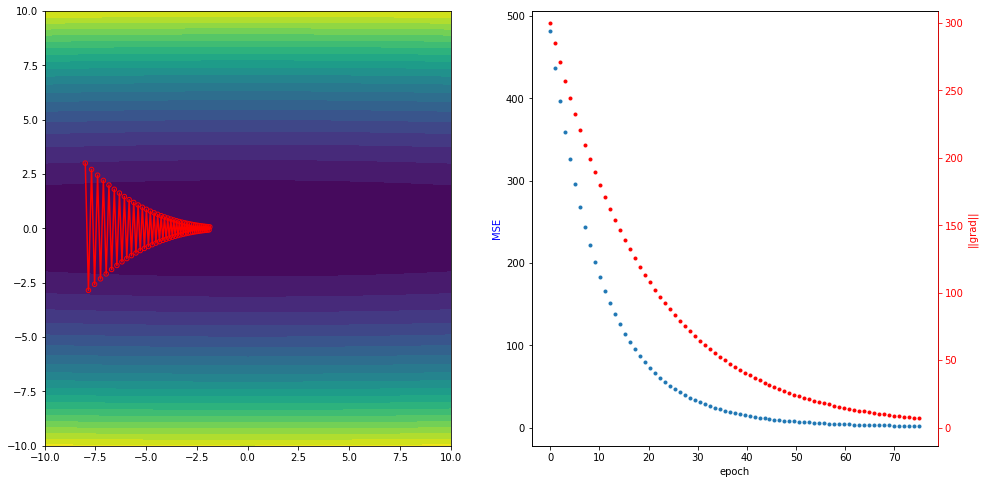

In [16]:
fig_rav

## Gradient Descent with Momentum

$$\begin{align}
v^{t+1}& = \mu v^{t} + (1-\beta)\nabla_p L(p^t)\\
p^{t+1}& = p^{t}-\eta v^{t+1}
\end{align}
$$

In [17]:
p = torch.FloatTensor([-8, 3])
p.requires_grad_(True);
gd = torch.optim.SGD([p], lr=0.0195, momentum=0.8, dampening=0.6)
fig_rav, ax =  plt.subplots(1,2,figsize=(16,8))


trajectory_gd = descend_ravine(75,p,gd)
plot_ravine(ax[0], trajectory_gd)
utils.plot_grad_and_trajectory(ax[1], trajectory_gd)

plt.close()

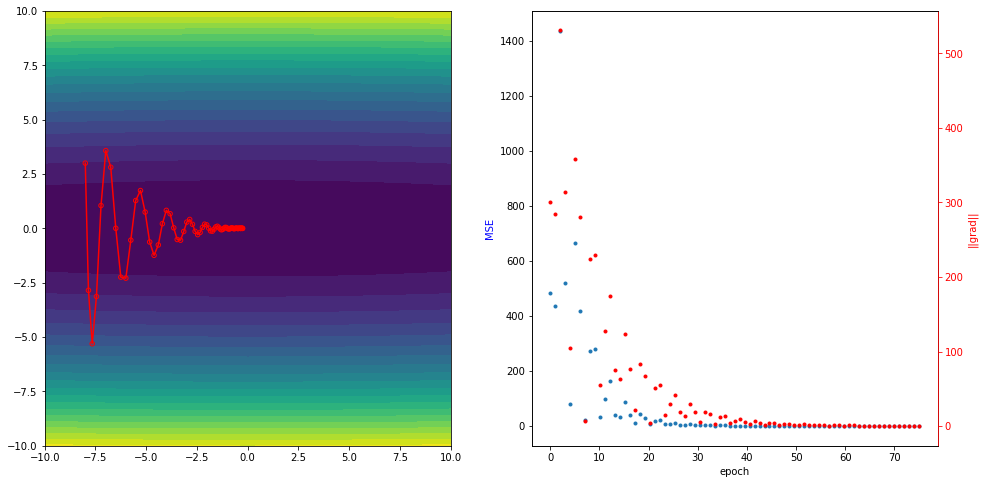

In [18]:
fig_rav

### Stochastic Gradient Descent

In [19]:
import torchvision

In [20]:
rdataset = torch.utils.data.TensorDataset(t_rxs, t_rys)

In [21]:
rdataloader = torch.utils.data.DataLoader(rdataset, batch_size=25, shuffle=True);

In [22]:
p = torch.FloatTensor([3.2, -0.4])
p.requires_grad_(True);
gd = torch.optim.SGD([p], lr=0.1, momentum=0.7, dampening=0.0, nesterov=False)

fig_gd_mom, ax =  plt.subplots(1,2,figsize=(16,8))
ax[0].contourf(otg[0], otg[1],vg, levels=20)
ax[0].scatter([p[0].item()], [p[1].item()],c='none', s=20, edgecolor='red')
trajectory_list=[]
n_iter = 50
for i in range(n_iter):
    n_batches = 0
    for d in rdataloader:
        n_batches+=1
        gd.zero_grad()
        x,y = d
        prediction = torch.sin(x*p[0]+p[1])
        loss = loss_f(prediction, y)
        loss.backward()
        gd.step()
        np_p = p.detach().numpy()
        trajectory_list.append(np.concatenate((p.grad.numpy(),np_p,[mse(fitf,rxs, rys,*np_p)])))
        ax[0].scatter([np_p[0]], [np_p[1]],c='red', s=20, edgecolor='red')

trajectory_gd=np.stack(trajectory_list)
utils.plot_grad_and_trajectory(ax[1], trajectory_gd, n_batches)
ax[1].set_xlabel("epoch")
plt.close()

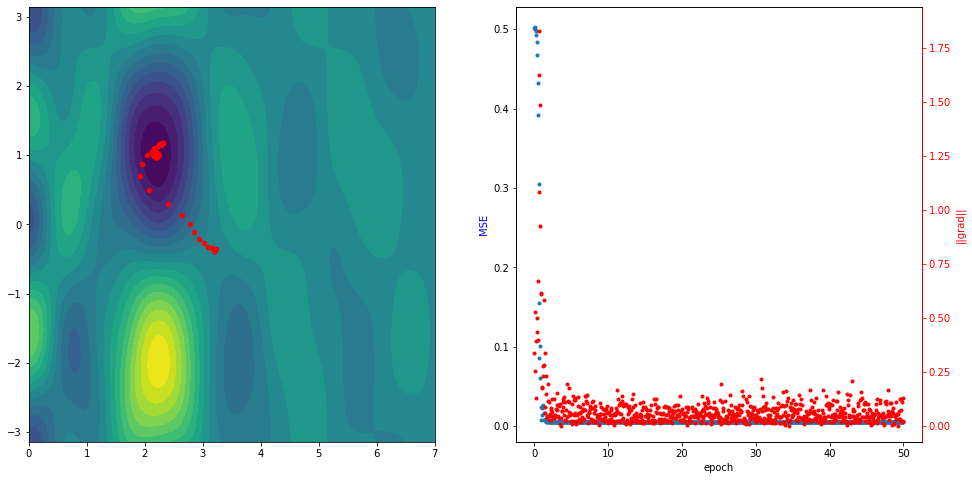

In [23]:
fig_gd_mom

$$\begin{align}
v^{t+1}& = \mu v^{t} + (1-\beta)\nabla_p L(p^t)\\
p^{t+1}& = p^{t}-\eta v^{t+1}
\end{align}
$$

$$v_{t+1} = \mu v_{t} + (1-\beta)G_t$$

$$v_1 = (1-\beta)G_0$$

$$v_2 = \mu (1-\beta)G_0+(1-\beta) G_1$$

$$v_3 = \mu\left(\mu (1-\beta)G_0+(1-\beta) G_1\right)+(1-\beta)G_2$$

$$v_3 = \mu^2 (1-\beta)G_0+\mu (1-\beta) G_1
+(1-\beta)G_2$$

$$v_t = (1-\beta)\sum_{i=1}^t \mu^{i-1}G_{t-i}$$

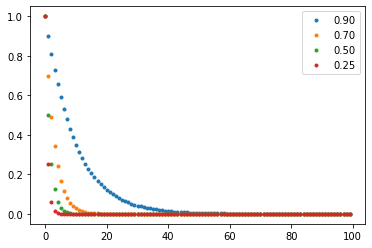

In [24]:
ns = np.arange(0,100)
for mu in [0.9, 0.7,0.5, 0.25]:
    plt.plot(ns,mu**ns,'.', label="%4.2f" % (mu,))
plt.legend();

## Nesterov Accelerated Gradient Descent

<p style="text-align:center;"> <img src="nesterov.jpg" /></p>

$$\begin{align}
v^{t+1}& = \mu v^{t} + \nabla_p L(p^t-\eta \mu v^t)\\
p^{t+1}& = p^{t}-\eta v^{t+1}
\end{align}
$$

$$r^t = p^t-\eta\mu v^t$$

$$p^t = r^t+\eta\mu v^t$$

$$\begin{align}
v^{t+1}& = \mu v^{t} + \nabla_r L(r)\\
r^{t+1}+\eta\mu v^{t+1}& = r^{t}+\eta\mu v^{t}-\eta v^{t+1}
\end{align}
$$

$$\begin{align}
v^{t+1}& = \mu v^{t} + \nabla_r L(r)\\
r^{t+1}& = r^{t}-\eta(1-\beta)\nabla_r L(r) - \eta\mu v^{t+1}
\end{align}
$$

$$\begin{align}
v^{t+1}& = \mu v^{t} + \nabla_r L(r)\\
r^{t+1}& = r^{t}-\eta\left(\nabla_r L(r) +\mu v^{t+1}\right)
\end{align}
$$

In [25]:
p = torch.FloatTensor([-8, 3])
p.requires_grad_(True);
gd = torch.optim.SGD([p], lr=0.0195, momentum=0.1, dampening=0.0, nesterov=True)
fig_rav, ax =  plt.subplots(1,2,figsize=(16,8))


trajectory_gd = descend_ravine(75,p,gd)
plot_ravine(ax[0], trajectory_gd)
utils.plot_grad_and_trajectory(ax[1], trajectory_gd)

plt.close()

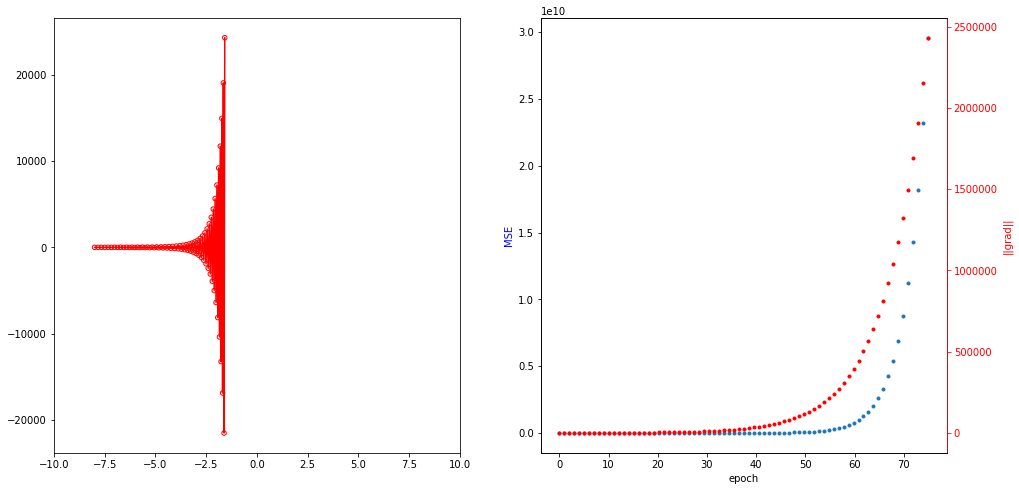

In [26]:
fig_rav

### Adam: Adaptive Momentum Estimation 

$$\begin{split}
m_t &= \beta_1 m_{t-1} + (1-\beta_1) g_t \\
v_t &= \beta_2 v_{t-1} + (1-\beta_2) g^2_t \\
\end{split}
$$

$$\theta_{t+1} = \theta_t -\frac{\eta}{\sqrt{v}+\epsilon}m_t $$

In [27]:
p = torch.FloatTensor([-8, 3])
p.requires_grad_(True);
gd = torch.optim.Adam([p], lr=0.1)
fig_rav, ax =  plt.subplots(1,2,figsize=(16,8))


trajectory_gd = descend_ravine(75,p,gd)
plot_ravine(ax[0], trajectory_gd)
utils.plot_grad_and_trajectory(ax[1], trajectory_gd)

plt.close()

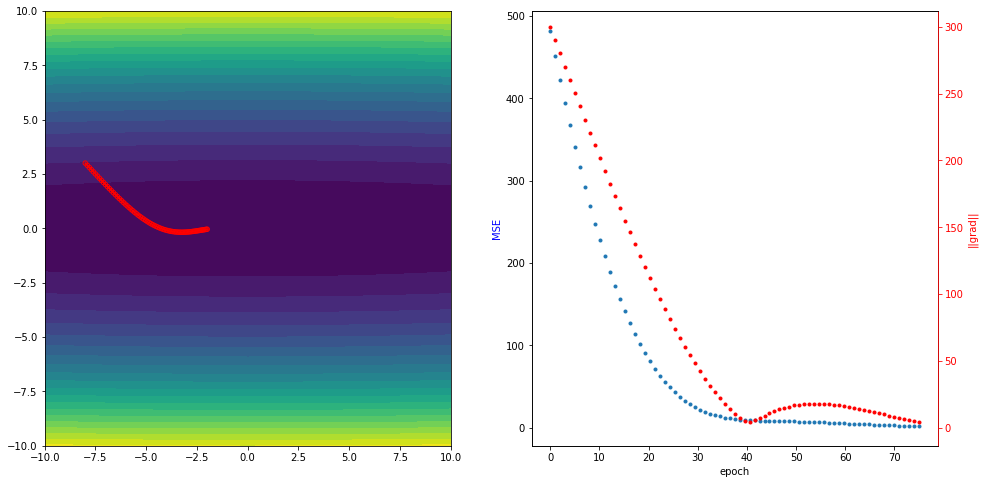

In [28]:
fig_rav

In [29]:
p = torch.FloatTensor([3.2, -0.4])
p.requires_grad_(True);
gd = torch.optim.Adam([p], lr=0.1 )

fig_gd_mom, ax =  plt.subplots(1,2,figsize=(16,8))
ax[0].contourf(otg[0], otg[1],vg, levels=20)
ax[0].scatter([p[0].item()], [p[1].item()],c='none', s=20, edgecolor='red')
trajectory_list=[]
n_iter = 50
for i in range(n_iter):
    n_batches = 0
    for d in rdataloader:
        n_batches+=1
        gd.zero_grad()
        x,y = d
        prediction = torch.sin(x*p[0]+p[1])
        loss = loss_f(prediction, y)
        loss.backward()
        gd.step()
        np_p = p.detach().numpy()
        trajectory_list.append(np.concatenate((p.grad.numpy(),np_p,[mse(fitf,rxs, rys,*np_p)])))
        ax[0].scatter([np_p[0]], [np_p[1]],c='red', s=20, edgecolor='red')

trajectory_gd=np.stack(trajectory_list)
utils.plot_grad_and_trajectory(ax[1], trajectory_gd, n_batches)
ax[1].set_xlabel("epoch")
plt.close()

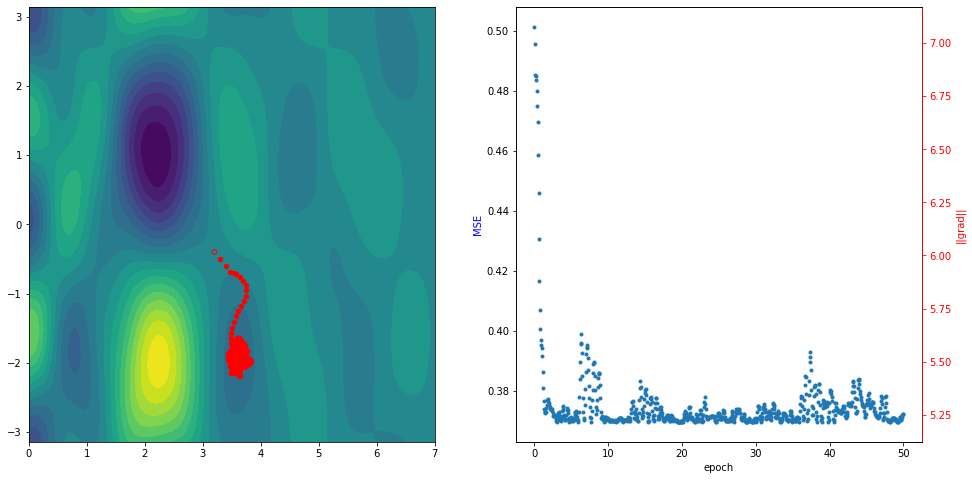

In [30]:
fig_gd_mom